In [1]:
import sys
import os

repo_root = "/home/druban/gpu_tests/ot-algorithm-comparison"
sys.path.insert(0, str(repo_root))

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [2]:
import jax
import logging
from uot.problems.generators.gaussian_mixture_generator import GaussianMixtureGenerator
from uot.solvers.base_solver import BaseSolver
from uot.utils.costs import cost_euclid_squared
from matplotlib import pyplot as plt
from uot.solvers.pdlp import PDLPSolver
from uot.solvers.sinkhorn import SinkhornTwoMarginalSolver
from uot.solvers.gradient_ascent import GradientAscentTwoMarginalSolver
from uot.solvers.ott_sinkhorn import OTTSinkhornSolver
from uot.experiments.experiment import Experiment
from uot.experiments.measurement import measure_time_and_precision, measure_pushforward
from uot.problems.problem_generator import ProblemGenerator
from uot.solvers.sinkhorn import SinkhornTwoMarginalLogJaxSolver
from uot.solvers.ot_pdlp import OT_PDLPSolver

2025-08-05 16:56:44.048512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754427404.064556 2958865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754427404.069387 2958865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754427404.081966 2958865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754427404.081982 2958865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754427404.081983 2958865 computation_placer.cc:177] computation placer alr

In [3]:
jax.config.update("jax_enable_x64", True)

In [9]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-2048p",
    dim=1,
    num_components=1,
    n_points=1024,
    num_datasets=5,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared,
    use_jax=False
)

In [10]:
problem = list(gaussian_generator.generate())[0]

In [14]:
OT_PDLPSolver().solve(
    marginals=problem.get_marginals(),
    costs=problem.get_costs(),
    reg=0.1,
    maxiter=10000,
    tol=1e-6
)

{'transport_plan': Array([[1.63777739e-06, 1.64308429e-06, 1.64839269e-06, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.63391126e-06, 1.63921559e-06, 1.64452150e-06, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.63002947e-06, 1.63533116e-06, 1.64063454e-06, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.85773777e-06, 4.85875767e-06, 4.85968629e-06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.86703386e-06, 4.86809866e-06, 4.86907188e-06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.87629271e-06, 4.87740245e-06, 4.87842030e-06]], dtype=float64),
 'cost': Array(0.08579104, dtype=float64),
 'u_final': Array([0.69479359, 0.69267257, 0.69055482, ..., 0.05143816, 0.05262864,
        0.05382376], dtype=float64),
 'v_final': Array([0.03997775, 0.03887436, 0.03777833, ..., 0.483850

In [13]:
PDLPSolver().solve(
    marginals=problem.get_marginals(),
    costs=problem.get_costs(),
    reg=10.0,
    maxiter=10000,
    tol=1e-6
)

{'transport_plan': Array([[6.69104697e-05, 6.47938911e-05, 6.26778963e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.84486824e-05, 5.70965355e-05, 5.57449725e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.92112804e-05, 4.86235652e-05, 4.80364340e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.06442518e-05, 9.47169973e-05, 9.84982342e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.49003468e-05, 9.97375241e-05, 1.04283193e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.90230479e-05, 1.04624657e-04, 1.09934757e-04]], dtype=float64),
 'cost': Array(0.02989723, dtype=float64),
 'u_final': Array([ 0.36384103,  0.36376015,  0.36367914, ..., -0.22546283,
        -0.22541647, -0.22536379], dtype=float64),
 'v_final': Array([-0.36317218, -0.36318952, -0.36319921, ...,

In [25]:
import pandas as pd

def run_experiments_on_dataset(
    generator: ProblemGenerator,
    regs: list[float],
    solvers: list[BaseSolver],
    **kwargs,
):
    ## Gather metrics first
    records = []
    experiment = Experiment(
        name="Time and precision",
        solve_fn=measure_time_and_precision
    )
    for solver in solvers:
        for reg in regs:
            df = experiment.run_on_problems(
                problems=generator.generate(),
                solver=solver,
                reg=reg,
                **kwargs,
            )

            records.append({
                'name': solver.__name__,
                'reg': reg,
                'avg_time': df["time"].mean(),
                'avg_cost_err': df["cost_err"].mean(),
            })

    df_result = pd.DataFrame(records)

    ## Plot the results

    # 1️⃣  Average runtime vs reg
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(generator._name)

    for name, sub in df_result.groupby("name"):
        ax1.plot(sub["reg"], sub["avg_time"], marker="o", label=name)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Regularisation $\\varepsilon$")
    ax1.set_title("Avg. Runtime")        # <- common prefix
    ax1.legend()

    # 2️⃣  Average cost‑error vs reg
    for name, sub in df_result.groupby("name"):
        ax2.plot(sub["reg"], sub["avg_cost_err"], marker="o", label=name)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_xlabel("Regularisation $\\varepsilon$")
    ax2.set_title("Avg. Precision")      # <- same prefix
    ax2.legend()

2025-08-05 14:34:23,125 uot INFO: Starting PDLPSolver with {'reg': 100.0, 'tol': 1e-06, 'maxiter': 100000} on <TwoMarginalProblem[Gaussian-1d-1024p] 1024x1024        with (<map object at 0x7f1ac9b14430>)>
2025-08-05 14:34:24,740 uot INFO: Successfully finished PDLPSolver with {'reg': 100.0, 'tol': 1e-06, 'maxiter': 100000}
2025-08-05 14:34:24,746 uot INFO: Starting PDLPSolver with {'reg': 10.0, 'tol': 1e-06, 'maxiter': 100000} on <TwoMarginalProblem[Gaussian-1d-1024p] 1024x1024        with (<map object at 0x7f1a38146e90>)>
2025-08-05 14:34:25,336 uot INFO: Successfully finished PDLPSolver with {'reg': 10.0, 'tol': 1e-06, 'maxiter': 100000}
2025-08-05 14:34:25,340 uot INFO: Starting PDLPSolver with {'reg': 1.0, 'tol': 1e-06, 'maxiter': 100000} on <TwoMarginalProblem[Gaussian-1d-1024p] 1024x1024        with (<map object at 0x7f1a38145150>)>
2025-08-05 14:34:26,301 uot INFO: Successfully finished PDLPSolver with {'reg': 1.0, 'tol': 1e-06, 'maxiter': 100000}
2025-08-05 14:34:26,305 uot INF

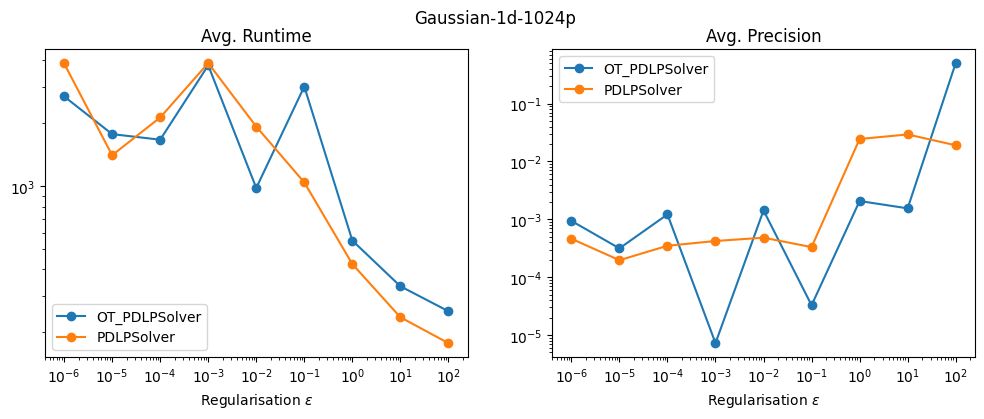

In [26]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-1024p",
    dim=1,
    num_components=1,
    n_points=1024,
    num_datasets=1,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared,
    use_jax=False
)

logger = logging.getLogger('uot')
logger.disabled = False

run_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6],
    solvers=[PDLPSolver, OT_PDLPSolver],
    tol=1e-6,
    maxiter=100000,
)

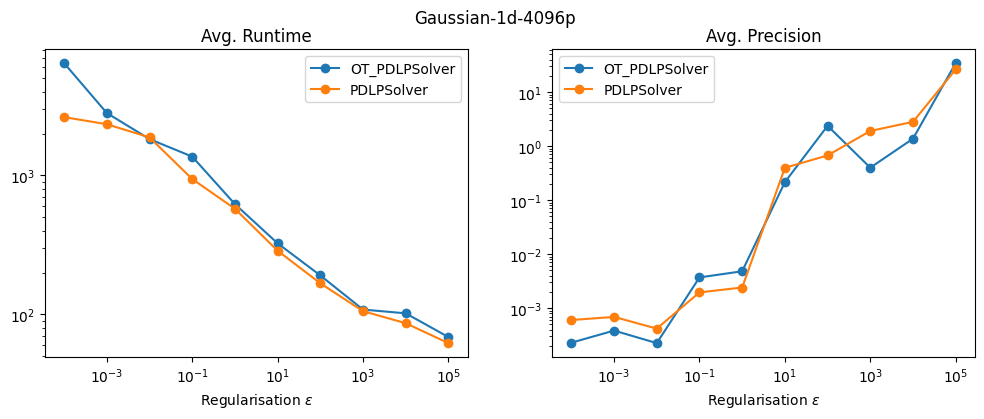

In [30]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-4096p",
    dim=1,
    num_components=2,
    n_points=2048,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared,
    use_jax=False
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, OT_PDLPSolver],
    tol=1e-6,
    maxiter=100000,
)

In [29]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-8192p",
    dim=1,
    num_components=2,
    n_points=8192,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, OT_PDLPSolver],
    tol=1e-6,
    maxiter=100000,
)

ValueError: not enough values to unpack (expected 4, got 3)

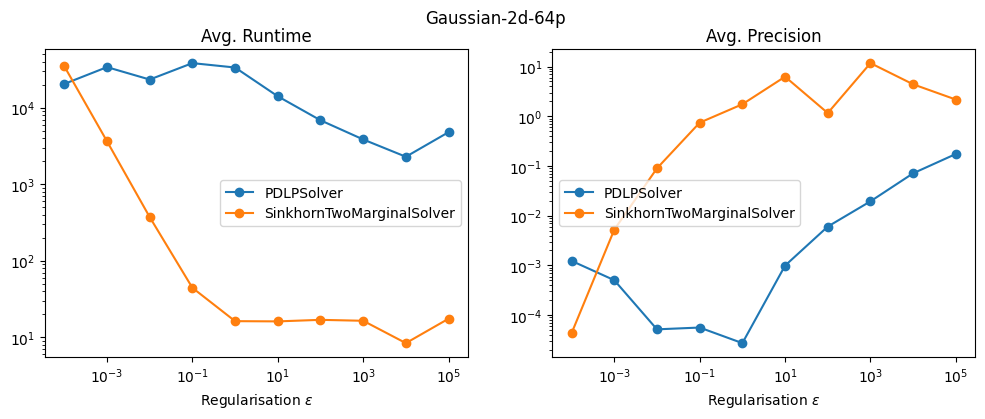

In [23]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-2d-64p",
    dim=2,
    num_components=1,
    n_points=64,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=100000,
)

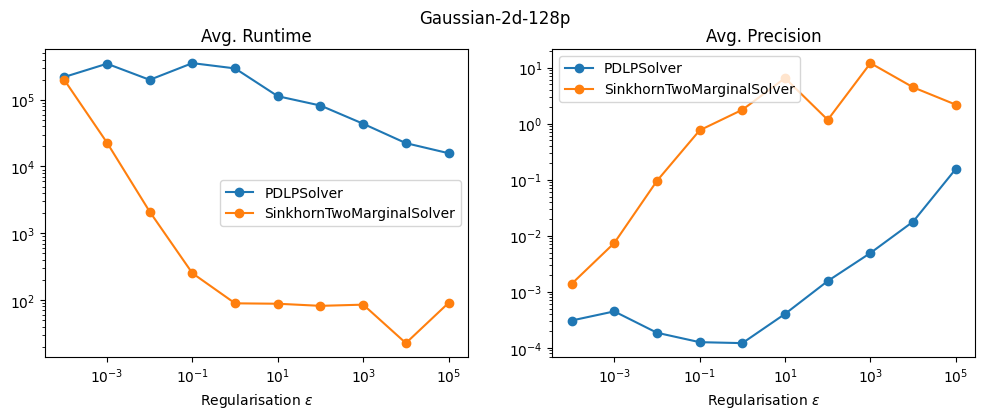

In [6]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-2d-128p",
    dim=2,
    num_components=1,
    n_points=128,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=100000,
)

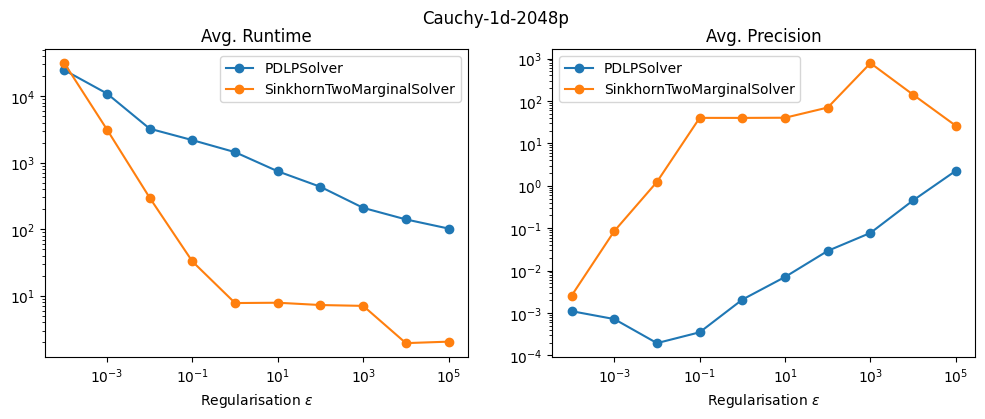

In [12]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-2048p",
    dim=1,
    n_points=2048,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=100000,
)

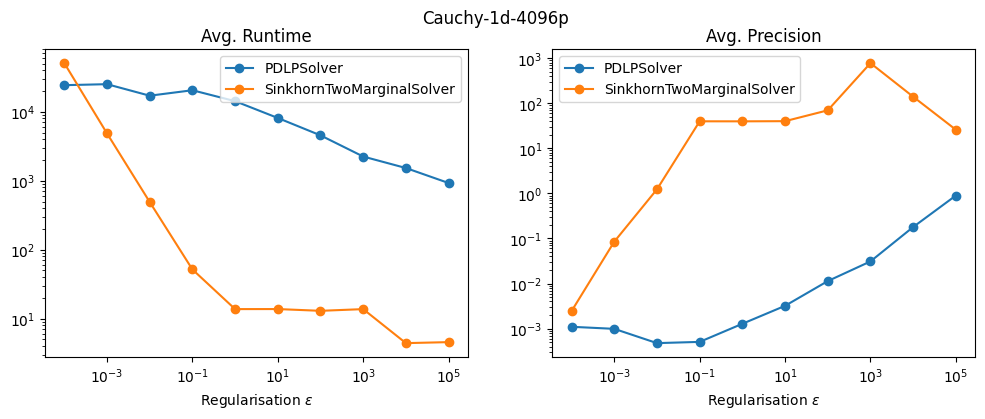

In [13]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-4096p",
    dim=1,
    n_points=4096,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=100000,
)

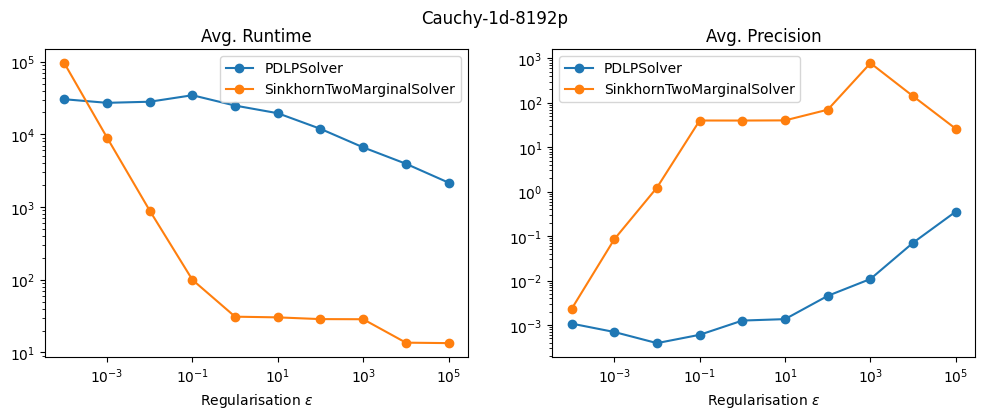

In [15]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-8192p",
    dim=1,
    n_points=8192,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=100000,
)

---

## 1 Notation

* **Source** $\displaystyle \mu=\sum_{i=1}^{n} a_i\delta_{x_i}$; $\,\, x_i\in\mathbb R^d$, $a_i>0$, $\sum_i a_i=1\,$.
* **Target** $\displaystyle \nu=\sum_{j=1}^{m} b_j\delta_{y_j}$; $\,\, y_j\in\mathbb R^d$, $b_j>0$, $\sum_j b_j=1\,$.
* **Regularised plans** $\pi_{\varepsilon}^{\text{ent}}$ (entropy) and
  $\pi_{\varepsilon}^{\text{L2}}$ (quadratic) are computed with Sinkhorn and
  PDLP.
* **Dual potential** $u$ comes from the OT dual.

---

## 2 Two approximations of the Monge map $T$

### (a) Barycentric projection

$$
T^{\mathrm{bar}}(x_i)=
\frac{1}{\mu_i}\sum_{j=1}^{m}\pi^{\mathrm{reg}}_{ij}\,y_j,
\qquad 1\le i\le n,
$$

with $\pi^{\mathrm{reg}}\in\{\pi_{\varepsilon}^{\text{ent}},
\pi_{\varepsilon}^{\text{L2}}\}$.
Each image point is the **centre of mass** of the mass leaving $x_i$
([Numerical Tours][5], [arXiv][3]).

### (b) Gradient‑of‑potential (theoretical)

* **Theory** (Brenier). For quadratic cost, the *exact* Monge map is the **gradient
  of a convex Brenier potential** $\psi$.
* **Discrete case**. When $\mu$ is discrete we only obtain the *vector*
  $\psi_i:=\tfrac12\|x_i\|^{2}-u_i$ at the support points $x_i$&#x20;
  (no continuous $\psi$).
* **Practical step**. Interpolate $\tilde{\psi}$ from discrete vector and compute approximate gradient $\nabla \tilde{\psi}$
* **Map**. The approximate Monge map is then

$$
T^{\mathrm{grad}}(x_i)=\nabla\tilde\psi(x_i),
$$

with the gradient taken numerically,
mirroring the continuous formula $\nabla\psi$ 

---

## 3 Push‑forwarded (reconstructed) measures

For either method $M\in\{\text{bar},\text{grad}\}$,

$$
\hat\nu^{M}=T^{M}_{\#}\mu=\sum_{i=1}^{n}a_i\,
\delta_{T^{M}(x_i)},
$$

where “$\#$” denotes the push‑forward of measures.

---

## 4 Bias / deviation metrics

- **$\ell_2$ error** $\|\,\hat \nu-\nu\|_2$
- **Wasserstein‑$2$** $\displaystyle W_2(\hat\nu,\nu)$

---

## 5 Evaluation recipe (per regulariser)

1. **Compute** $\pi_{\varepsilon}^{\text{reg}}$.
2. **Maps**: obtain $T^{\mathrm{bar}}$ and $T^{\mathrm{grad}}$.
3. **Push‑forward**: build $\hat\nu^{\mathrm{bar}},\hat\nu^{\mathrm{grad}}$.
4. **Bias numbers**:

$$
\text{Bias}^{\mathrm{reg},M}_{\ell_2},\quad
\text{Bias}^{\mathrm{reg},M}_{W_p},\qquad
M\in\{\text{bar},\text{grad}\}.
$$





In [7]:
import pandas as pd

def run_pushforward_experiments_on_dataset(
    generator: ProblemGenerator,
    regs: list[float],
    solvers: list[BaseSolver],
    **kwargs,
):
    ## Gather metrics first
    records = []
    experiment = Experiment(
        name="Pushforward bias",
        solve_fn=measure_pushforward
    )
    for solver in solvers:
        for reg in regs:
            df = experiment.run_on_problems(
                problems=generator.generate(),
                solver=solver,
                reg=reg,
                **kwargs,
            )

            records.append({
                'name': solver.__name__,
                'reg': reg,
                'avg_barycentric_l2_bias': df["barycentric_l2_bias"].mean(),
                'avg_barycentric_w2_bias': df["barycentric_w2_bias"].mean(),
                'avg_monge_l2_bias': df["monge_l2_bias"].mean(),
                'avg_monge_w2_bias': df["monge_w2_bias"].mean(),
            })

    df_result = pd.DataFrame(records)

    ## Plot the results

    # 1️⃣  Average runtime vs reg
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    fig.suptitle(generator._name)

    for name, sub in df_result.groupby("name"):
        ax1.plot(sub["reg"], sub["avg_barycentric_l2_bias"], marker="o", label=name)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    # ax1.set_xlabel("Regularisation $\\varepsilon$")
    ax1.set_title("Avg. Bar. L2 bias")        # <- common prefix
    ax1.legend()

    # 2️⃣  Average cost‑error vs reg
    for name, sub in df_result.groupby("name"):
        ax2.plot(sub["reg"], sub["avg_barycentric_w2_bias"], marker="o", label=name)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    # ax2.set_xlabel("Regularisation $\\varepsilon$")
    ax2.set_title("Avg. Bar. Wasserstein bias")      # <- same prefix
    ax2.legend()

    for name, sub in df_result.groupby("name"):
        ax3.plot(sub["reg"], sub["avg_monge_l2_bias"], marker="o", label=name)
    ax3.set_xscale("log")
    ax3.set_yscale("log")
    ax3.set_xlabel("Regularisation $\\varepsilon$")
    ax3.set_title("Avg. Monge L2 bias")        # <- common prefix
    ax3.legend()

    # 2️⃣  Average cost‑error vs reg
    for name, sub in df_result.groupby("name"):
        ax4.plot(sub["reg"], sub["avg_monge_w2_bias"], marker="o", label=name)
    ax4.set_xscale("log")
    ax4.set_yscale("log")
    ax4.set_xlabel("Regularisation $\\varepsilon$")
    ax4.set_title("Avg. Monge Wasserstein bias")      # <- same prefix
    ax4.legend()

In [ ]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-1024p",
    dim=1,
    num_components=1,
    n_points=1024,
    num_datasets=1,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared,
    use_jax=False
)

logger = logging.getLogger('uot')
logger.disabled = False

run_pushforward_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-6,
    maxiter=200000,
)

2025-07-30 20:14:17,613 uot INFO: Starting PDLPSolver with {'reg': 100000.0, 'tol': 1e-06, 'maxiter': 200000} on <TwoMarginalProblem[Gaussian-1d-1024p] 1024x1024        with (<map object at 0x7f101c42f610>)>


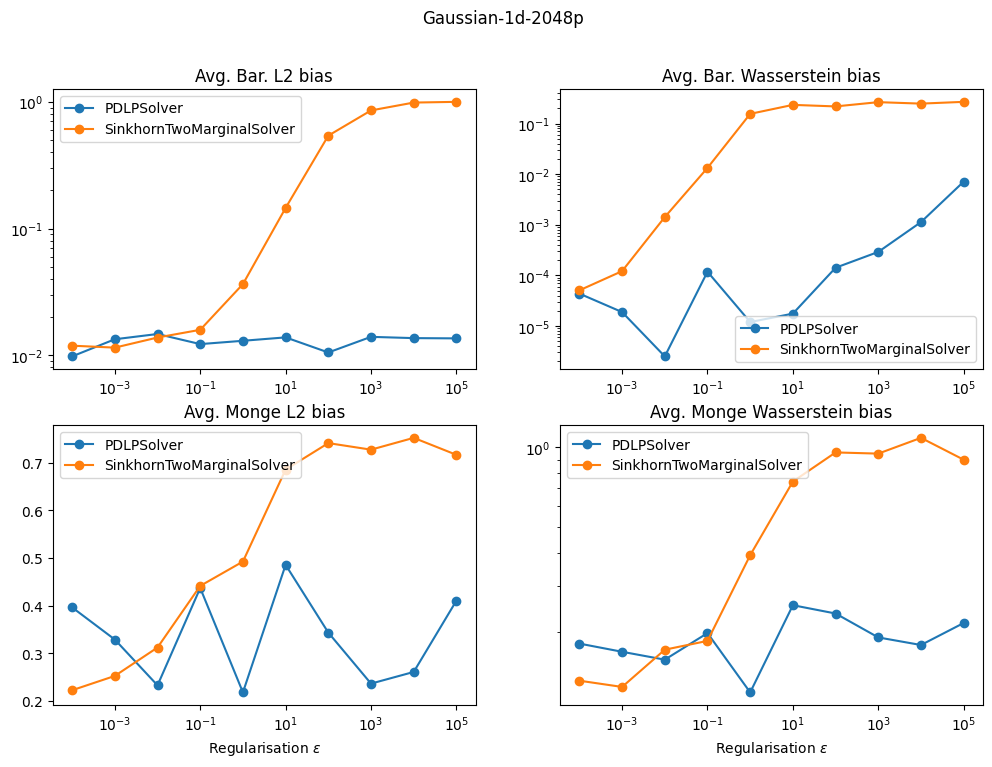

In [19]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-2048p",
    dim=1,
    num_components=1,
    n_points=2048,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


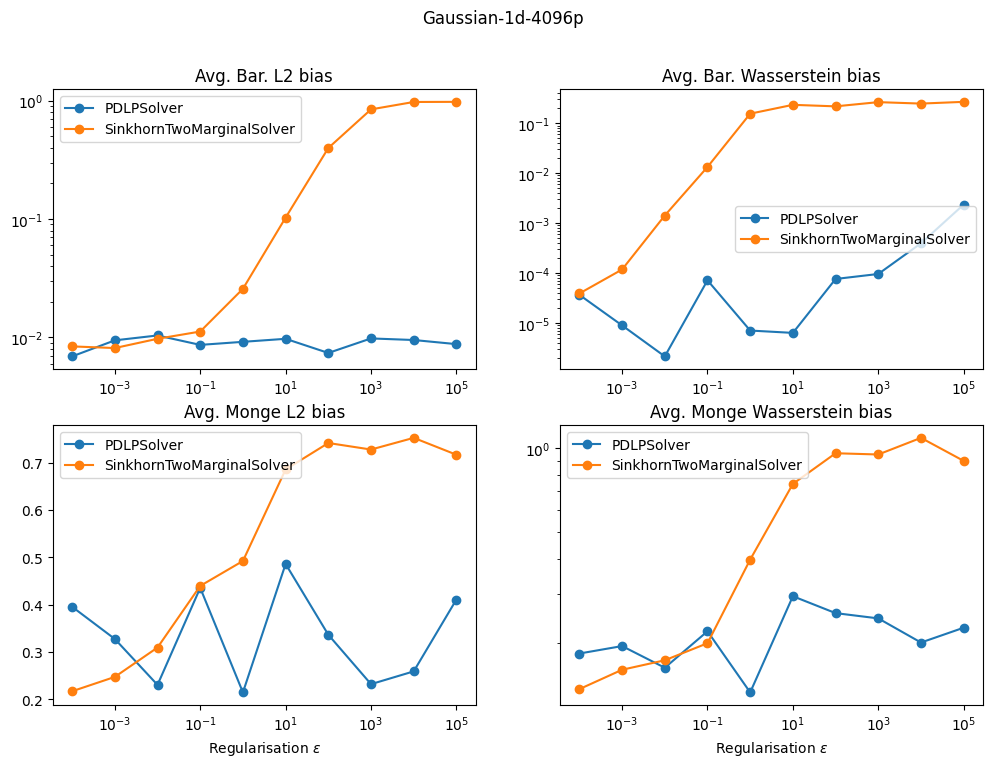

In [20]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-4096p",
    dim=1,
    num_components=1,
    n_points=4096,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


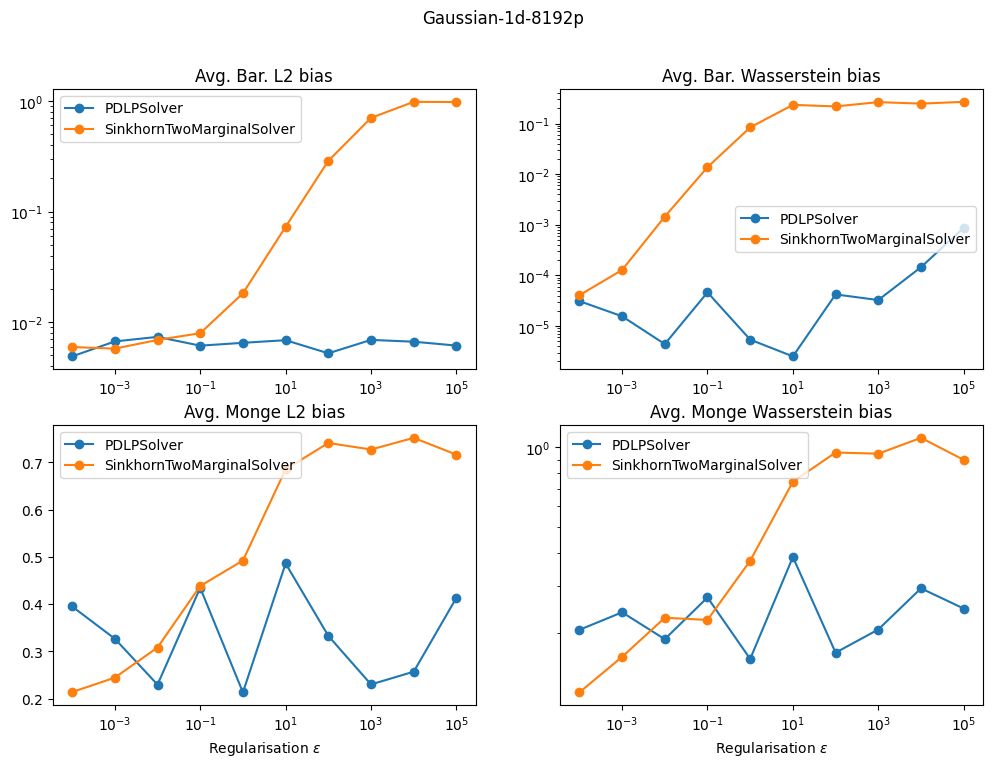

In [22]:
gaussian_generator = GaussianMixtureGenerator(
    name="Gaussian-1d-8192p",
    dim=1,
    num_components=1,
    n_points=8192,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=gaussian_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)

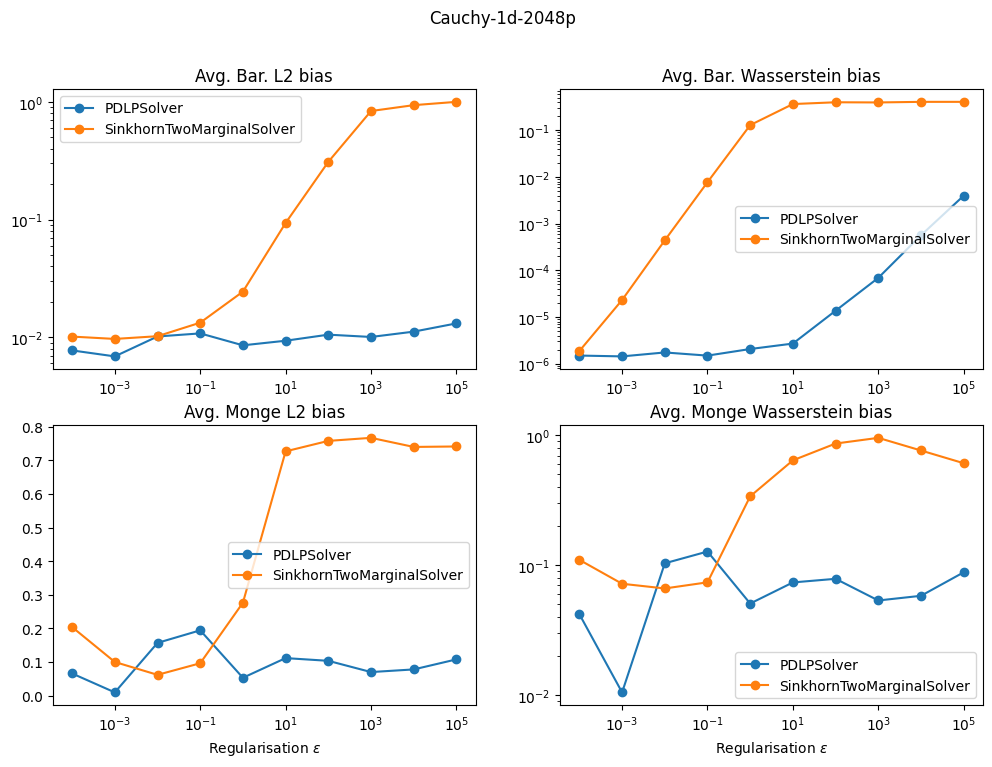

In [16]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-2048p",
    dim=1,
    n_points=2048,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


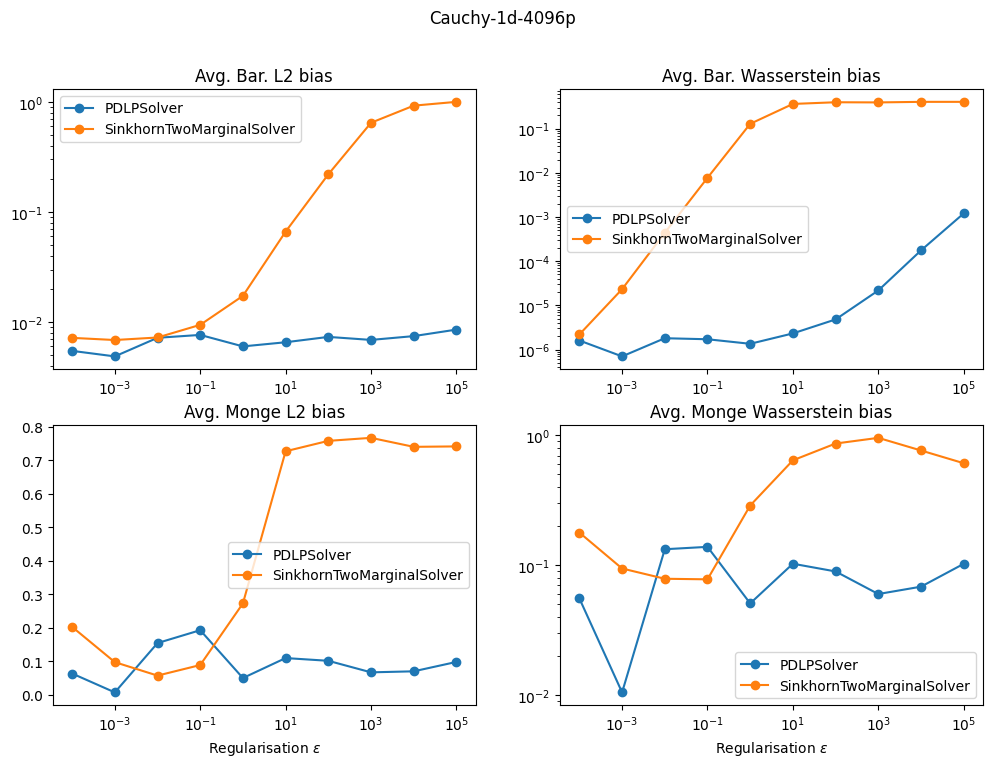

In [17]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-4096p",
    dim=1,
    n_points=4096,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


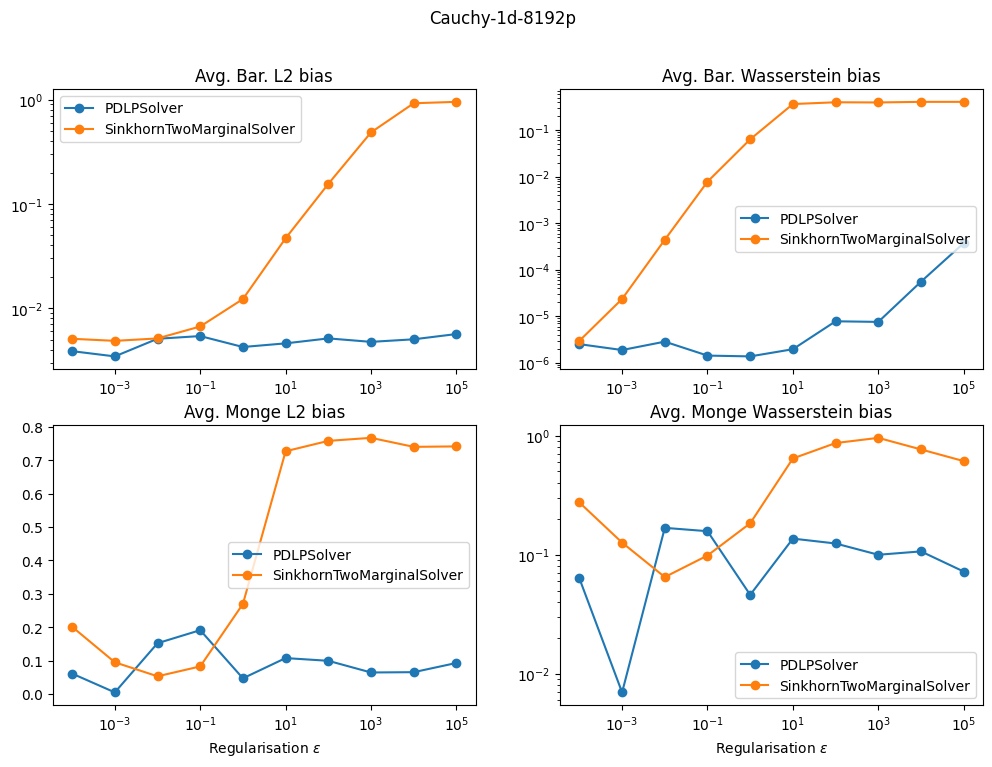

In [18]:
from uot.problems.generators.cauchy_generator import CauchyGenerator

cauchy_generator = CauchyGenerator(
    name="Cauchy-1d-8192p",
    dim=1,
    n_points=8192,
    num_datasets=10,
    borders=[-1, 1],
    cost_fn=cost_euclid_squared
)

logger = logging.getLogger('uot')
logger.disabled = True

run_pushforward_experiments_on_dataset(
    generator=cauchy_generator,
    regs=[1e5, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
    solvers=[PDLPSolver, SinkhornTwoMarginalSolver],
    tol=1e-8,
    maxiter=200000,
)